In [177]:
import matplotlib
import numpy as np
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import pandas as pd
import psycopg2 as pg
pass_file = "/mnt/data/mvesc/PartnerData/default_profile"
f = open(pass_file, 'r')
with open(pass_file, 'r') as f:
   passinfo = f.readlines()
f.close()

In [5]:
database_credentials = [line.strip().split("=")[1] for line in passinfo]
#database_credentials # don't print this out in Jupyter notebook for world to see!

In [9]:
host_address = database_credentials[0]
user_name = database_credentials[1]
name_of_database = database_credentials[2]
user_password = database_credentials[3]
conn = pg.connect(host=host_address, database=name_of_database, user=user_name, password=user_password)
cursor = conn.cursor()
sqlcmd_table_names = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"
cursor.execute(sqlcmd_table_names)
table_names = cursor.fetchall()
print(table_names)

[('DistrictSchoolIDs',), ('all_lookup',), ('CurrentMobility',), ('CurrentStudents',), ('ASQ_Preschool',), ('ActScores',), ('AllDistricts1112',), ('HSGrades',), ('AllDistricts1213',), ('AIRScores',), ('AllDistricts1314',), ('CurrentAbsenceDiscipline',), ('DIBELSv2',), ('AllDistricts1415',), ('AllGradsTotal',), ('OAAOGT',), ('PARCC',), ('StarRead',), ('StarEL',), ('StarMath',), ('TerraNova',)]


In [12]:
def read_table_to_df(table_name, connection):
    """ Takes a table name as input and returns postgres table as pandas data frame.
    
    :param string table_name: Name of table to read in
    :param psycopg2.connection connection: POSTGRESQL connection object for Python
    :return: a Pandas dataframe object containing the desired table
    :rtype: Pandas.dataframe
    """
    sql_query = "SELECT * FROM \"" + table_name + "\";"
    data = pd.read_sql(sql_query, connection)
    return data

In [10]:
ALL_DISTRICTS_TABLES = ["AllDistricts" + str(num) + str(num+1) for num in range(11,15)]
ALL_DISTRICTS_TABLES.append("CurrentStudents")
ALL_DISTRICTS_TABLES

['AllDistricts1112',
 'AllDistricts1213',
 'AllDistricts1314',
 'AllDistricts1415',
 'CurrentStudents']

In [13]:
all_districts_data = [read_table_to_df(table_name, conn) for table_name in ALL_DISTRICTS_TABLES]

In [126]:
# However, for the all_districts_data, how are we going to handle the null lookup numbers? 
# Let's duplicate the dataframes and drop the null lookups for now, hopefully they won't be null for long
all_districts_copied = [None] * len(all_districts_data)
for i, df in enumerate(all_districts_data):
    df2 = df[pd.notnull(df.StudentLookup)]
    all_districts_copied[i] = df2.set_index("StudentLookup")

In [212]:
dict_all_districts = {k:v for (k,v) in zip(ALL_DISTRICTS_TABLES, all_districts_copied)}
dict_all_districts.keys()

dict_keys(['AllDistricts1213', 'AllDistricts1314', 'AllDistricts1415', 'CurrentStudents', 'AllDistricts1112'])

In [15]:
all_grads = read_table_to_df("AllGradsTotal", conn)
current_mobility = read_table_to_df("CurrentMobility", conn)
current_absence_discipline = read_table_to_df("CurrentAbsenceDiscipline", conn)

In [19]:
# There are two very similar looking codes for economic/academic disadvantage: 
# "1 - Economic disadvantagement" and "Economic Disadvantagement"
# Let's just check if the coding scheme has changed over time or varies district to district

def get_unique_stripped_sorted_values(sort_column, coding, 
                                      code_column = "Disadvantaged", data = all_grads):
    """Subsets a dataframe by rows containing particular value in the code column, and then strips and 
       sorts all unique values in sort column of the matching rows. Returns these unique sorted values 
       in a list.
       
    :param string sort_column: Name of the column to find unique values of (for matching rows)
    :param string coding: Value of the code to subset the data by
    :param string code_column: Column to find the code to subset the data by
    :param Pandas.dataframe data: input dataframe
    :return: a list containing unique values in specified column for the matching rows
    :rtype: list[dtype of sort_column] 
    """
    unique_values_for_code = data[sort_column][data[code_column] == coding].unique()
    unique_values_for_code_stripped = [d.strip() for d in unique_values_for_code]
    unique_values_for_code_stripped.sort()
    return(unique_values_for_code_stripped)

districts_codetype1 = get_unique_stripped_sorted_values(sort_column = "DistrictCode", 
                                                        coding = "1 - Economic disadvantagement")
districts_codetype2 = get_unique_stripped_sorted_values(sort_column = "DistrictCode", 
                                                        coding = "Economic Disadvantagement")
print(districts_codetype1)
print(districts_codetype2)

grad_date_codetype1 = get_unique_stripped_sorted_values(sort_column = "HIGH_SCHOOL_GRAD_DATE",
                                                        coding = "1 - Economic disadvantagement")
grad_date_codetype2 = get_unique_stripped_sorted_values(sort_column = "HIGH_SCHOOL_GRAD_DATE",
                                                        coding = "Economic Disadvantagement")

print("%s to %s" % (grad_date_codetype1[0], grad_date_codetype1[-1]))
print("%s to %s" % (grad_date_codetype2[0], grad_date_codetype2[-1]))

['D13', 'D15', 'D5', 'D7', 'D8']
['D1', 'D10', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
20110114 to 20150630
20110516 to 20150701


In [15]:
# all_grads.Disadvantaged.replace(to_replace="1 - Economic disadvantagement", 
#                                value="Economic Disadvantagement", inplace=True)
# all_grads.Disadvantaged.replace(to_replace="2 - Academic disadvantagement", 
#                                value="Academic Disadvantagement", inplace=True)

In [20]:
all_grads_valuecounts = {colname: all_grads[colname].value_counts(dropna=False) for colname in all_grads.columns}

How many students are not disadvantaged? Economic ? Academic ? It isn't clear why there are two coding types for each, or why there are so few academic disadvantaged students in the data -- but this is grads only.

In [21]:
all_grads_valuecounts["Disadvantaged"]

                                          5488
Economic Disadvantagement                 3208
1 - Economic disadvantagement              475
Academic Disadvantagement                   19
Economic and Academic Disadvantagement       7
2 - Academic disadvantagement                1
Name: Disadvantaged, dtype: int64

In [186]:
district_by_district = all_grads.groupby("DistrictCode")
district_disadvantaged_counts = district_by_district.Disadvantaged.value_counts(dropna=False)
district_disadvantaged_counts.to_frame().head()

Disadvantaged
DistrictCode Disadvantaged                           
D1           Economic Disadvantagement            138
                                                  127
             Academic Disadvantagement              5
D10          Economic Disadvantagement            189
                                                  132

In [194]:
all_grads['grad_date_formatted'] = pd.to_datetime(all_grads.HIGH_SCHOOL_GRAD_DATE, format = "%Y%m%d")
all_grads['grad_year'] = pd.Series(grad_date.year for grad_date in all_grads.grad_date_formatted)
all_grads.grad_year.value_counts(dropna=False)
all_grads.grad_year.unique()

2015    2055
2013    1898
2011    1762
2012    1742
2014    1741
dtype: int64

array([2011, 2014, 2013, 2012, 2015])

In [373]:
all_districts_copied[0].CURRENT_GRADE.value_counts(dropna=False)
all_districts_copied[1].CURRENT_GRADE.value_counts(dropna=False)
all_districts_copied[2].CURRENT_GRADE.value_counts(dropna=False)
all_districts_copied[3].CURRENT_GRADE.value_counts(dropna=False)
all_districts_copied[4].CURRENT_GRADE.value_counts(dropna=False)




06    2272
07    2239
01    2227
08    2219
05    2201
04    2165
03    2141
02    2101
09    2053
KG    2045
11    1853
12    1770
10    1721
PS     768
23      40
13      18
-2      12
14       3
UG       3
Name: CURRENT_GRADE, dtype: int64

07    2353
09    2334
02    2309
KG    2305
08    2283
06    2266
05    2251
04    2211
03    2164
01    2157
10    2078
12    1886
11    1748
PS     932
23      40
13      21
14       6
-2       5
UG       1
Name: CURRENT_GRADE, dtype: int64

09    2401
08    2369
10    2339
07    2319
06    2319
03    2310
01    2283
05    2198
KG    2193
04    2163
02    2129
11    2063
12    1736
PS     810
23      31
13      19
14       3
Name: CURRENT_GRADE, dtype: int64

09    2510
10    2465
07    2447
08    2421
01    2401
02    2399
04    2393
11    2382
KG    2368
06    2337
05    2281
03    2278
12    2119
PS    1123
23      31
13      20
14       3
Name: CURRENT_GRADE, dtype: int64

11    2853
12    2776
10    2663
09    2591
03    2542
08    2524
02    2489
05    2488
07    2446
KG    2412
01    2400
06    2374
04    2308
PS    1364
23      56
13      37
14       3
GR       1
Name: CURRENT_GRADE, dtype: int64

In [53]:
# Get the student lookup numbers grouped by year of high school graduation
# students_by_grad_year is now a groupby object, keys are graduation years
# values are student lookups of all students who graduated in that year (calendar year, not academic year currently)
students_by_grad_year = all_grads["StudentLookup"].groupby(all_grads["grad_year"])
students_by_grad_year.groups.keys()

dict_keys([2011, 2012, 2013, 2014, 2015])

In [ ]:
# This will be a whole lot easier if we set Student Lookup column as the pandas row index
all_grads.set_index("StudentLookup", inplace = True)

In [254]:
def get_graduates_in_snapshots(grad_year, table_names, 
                               graduate_data = all_grads, district_tables = dict_all_districts):
    """Search for all high school graduates within a given calendar year. Returns list of student lookup numbers
       whose records can be found within a particular academic year snapshot table (or list of tables).
       
    :param int grad_year: Year to subset high school graduation date by 
    :param list[string] table_names: list of table names (see ALL_DISTRICTS_TABLES) in which to search for student 
                        yearly academic records
    :param Pandas.dataframe all_grads: dataframe containing all high school graduates including graduation date
    :param dict(list[string]: list[Pandas.dataframe]) district_tables: dict of dataframes containing yearly academic 
                        snapshots for all students in a particular academic year, referenced by table name
    :return: list of student lookup numbers that graduated in specified year and whose records found in specified table
    :rtype: Int64Index
    """
    district_tables_to_search = [district_tables[table] for table in table_names]
    grads_for_spec_year = graduate_data.index[graduate_data.grad_year == grad_year]
    
    # union the student lookups covered in all district tables given to get all students covered
    all_students = set()
    for student_year in district_tables_to_search:
        z = set(student_year.index)
        all_students = all_students.union(z)
    grads_in_district_tables = grads_for_spec_year[[graduate in all_students for graduate in grads_for_spec_year]]
    return(grads_in_district_tables)

In [262]:
# How many graduates do we have in our records for each year and how many of those can be found in the 
# year by year district lookup tables for at least one year?
# Also build a dictionary with student lookup of valid grads by graduation year key

all_grads_in_tables = {}
for grad_year in range(2011, 2016):
    total_grads = sum(all_grads.grad_year == grad_year)
    grads_in_tables = get_graduates_in_snapshots(grad_year, list(dict_all_districts.keys()))
    all_grads_in_tables[grad_year] = grads_in_tables
    
    print("total graduates in %d: %d\t num grads in district tables: %d" % 
          (grad_year, total_grads, len(grads_in_tables)))

total graduates in 2011: 1762	 num grads in district tables: 18
total graduates in 2012: 1742	 num grads in district tables: 1726
total graduates in 2013: 1898	 num grads in district tables: 1883
total graduates in 2014: 1741	 num grads in district tables: 1722
total graduates in 2015: 2055	 num grads in district tables: 2041


In [360]:
def get_student_field_from_districts(student_num, field_name, district_tables = all_districts_copied, 
                                     flag_if_diff = True):
    """Search for a value for a particular field (i.e. DOB) for a particular student. If field is missing, go to next 
       district table in list of tables until some value of field is found. Check that all tables contain the same
       value of the given field (where student lookup number is found)
       
    :param int student_num: student lookup number to search for
    :param string field_name: name of a column in which to search for the student's value 
                              (should not change from year to year)
    :param list[Pandas.dataframe] district_tables:  
    :return: single value for a given student for the specified field name
    :rtype: list[dtype of district_tables.field_name] (should usually be a list of length 1)
    """
    # print(student_num)
    student_value = set()
    for table in district_tables:
        if student_num in table.index: # check if the student exists in the current table
            get_student_row = table.loc[student_num][field_name] # get student's full record(s) from table
            try: 
                student_value.add(get_student_row) 
            except TypeError:
                for row in get_student_row: # add each of student's duplicated records separately
                    student_value.add(row)
    if flag_if_diff:
        if (len(student_value) > 1): # check if all existing non-null fields for a particular student match
            print("Conflicting values for student %d in %s" % (student_num, field_name))
    if len(student_value) == 0:
        student_value.add(None)
    return(student_value)

In [361]:
%%time

student_num_list = all_grads_in_tables[2015]
# table = all_districts_copied[0]
field_name = "DATE_OF_BIRTH"

grads_2015_date_of_birth = {student_num: get_student_field_from_districts(student_num, field_name).pop()
                                    for student_num in student_num_list}


Conflicting values for student 38390 in DATE_OF_BIRTH
Conflicting values for student 42458 in DATE_OF_BIRTH
Conflicting values for student 43056 in DATE_OF_BIRTH
Conflicting values for student 43074 in DATE_OF_BIRTH
Conflicting values for student 43305 in DATE_OF_BIRTH
Conflicting values for student 43498 in DATE_OF_BIRTH
CPU times: user 18min 21s, sys: 298 ms, total: 18min 22s
Wall time: 18min 57s


In [364]:
get_student_field_from_districts(38390, field_name)
get_student_field_from_districts(42458, field_name)
get_student_field_from_districts(43056, field_name)
get_student_field_from_districts(43074, field_name)
get_student_field_from_districts(43305, field_name)
get_student_field_from_districts(43498, field_name)

Conflicting values for student 38390 in DATE_OF_BIRTH


{Timestamp('1995-12-10 00:00:00'), Timestamp('1996-12-10 00:00:00')}

Conflicting values for student 42458 in DATE_OF_BIRTH


{Timestamp('1997-07-21 00:00:00'), Timestamp('1997-07-27 00:00:00')}

Conflicting values for student 43056 in DATE_OF_BIRTH


{Timestamp('1996-11-10 00:00:00'), Timestamp('1997-11-10 00:00:00')}

Conflicting values for student 43074 in DATE_OF_BIRTH


{Timestamp('1996-08-08 00:00:00'), Timestamp('1997-02-05 00:00:00')}

Conflicting values for student 43305 in DATE_OF_BIRTH


{Timestamp('1996-07-01 00:00:00'), Timestamp('1996-07-11 00:00:00')}

Conflicting values for student 43498 in DATE_OF_BIRTH


{Timestamp('1997-05-05 00:00:00'), Timestamp('1997-05-22 00:00:00')}

In [367]:
len(student_num_list)
len(grads_2015_date_of_birth)

2041

2041

In [372]:
%%time

student_num_list = all_grads_in_tables[2014]
grads_2014_date_of_birth = {student_num: get_student_field_from_districts(student_num, field_name).pop()
                                    for student_num in student_num_list}
student_num_list = all_grads_in_tables[2013]
grads_2013_date_of_birth = {student_num: get_student_field_from_districts(student_num, field_name).pop()
                                    for student_num in student_num_list}
student_num_list = all_grads_in_tables[2012]
grads_2012_date_of_birth = {student_num: get_student_field_from_districts(student_num, field_name).pop()
                                    for student_num in student_num_list}
student_num_list = all_grads_in_tables[2011]
grads_2011_date_of_birth = {student_num: get_student_field_from_districts(student_num, field_name).pop()
                                    for student_num in student_num_list}

Conflicting values for student 36427 in DATE_OF_BIRTH
Conflicting values for student 37174 in DATE_OF_BIRTH
Conflicting values for student 41453 in DATE_OF_BIRTH
Conflicting values for student 40269 in DATE_OF_BIRTH
Conflicting values for student 41793 in DATE_OF_BIRTH
CPU times: user 23min 38s, sys: 254 ms, total: 23min 38s
Wall time: 24min 20s


In [433]:
%%time

years = range(2011, 2016)
grads_dateofgraduation = [None] * len(years)
for i, gradyear in enumerate(years):
    student_num_list = all_grads_in_tables[gradyear]
    graduation_dates = {student_num: pd.to_datetime(all_grads.HIGH_SCHOOL_GRAD_DATE.loc[student_num], 
                                    format = "%Y%m%d") for student_num in student_num_list}
    grads_dateofgraduation[i] = graduation_dates
    


CPU times: user 4.42 s, sys: 76.9 ms, total: 4.5 s
Wall time: 4.54 s


In [397]:
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

In [381]:
grads_2011_birthyear = Counter()
for student, dob in grads_2011_date_of_birth.items():
    birthyear = dob.year
    grads_2011_birthyear[birthyear] += 1
grads_2011_birthyear

In [383]:
grads_2012_birthyear = Counter()
for student, dob in grads_2012_date_of_birth.items():
    birthyear = dob.year
    grads_2012_birthyear[birthyear] += 1
grads_2012_birthyear

Counter({1990: 3, 1991: 3, 1992: 33, 1993: 761, 1994: 918, 1995: 8})

In [384]:
grads_2013_birthyear = Counter()
for student, dob in grads_2013_date_of_birth.items():
    birthyear = dob.year
    grads_2013_birthyear[birthyear] += 1
grads_2013_birthyear

Counter({1991: 4, 1992: 9, 1993: 58, 1994: 855, 1995: 949, 1996: 8})

In [385]:
grads_2014_birthyear = Counter()
for student, dob in grads_2014_date_of_birth.items():
    birthyear = dob.year
    grads_2014_birthyear[birthyear] += 1
grads_2014_birthyear

Counter({1992: 7, 1993: 10, 1994: 62, 1995: 785, 1996: 849, 1997: 8, 1999: 1})

In [386]:
grads_2015_birthyear = Counter()
for student, dob in grads_2015_date_of_birth.items():
    birthyear = dob.year
    grads_2015_birthyear[birthyear] += 1
grads_2015_birthyear

Counter({1993: 3, 1994: 5, 1995: 58, 1996: 1007, 1997: 955, 1998: 13})

In [440]:
grads_dateofbirth = [grads_2011_date_of_birth, grads_2012_date_of_birth, grads_2013_date_of_birth,
                     grads_2014_date_of_birth, grads_2015_date_of_birth]
[a.keys() == b.keys() for a, b in zip(grads_dateofbirth, grads_dateofgraduation)]

[True, True, True, True, True]

In [493]:
#from dateutil.relativedelta import relativedelta

def get_student_age_from_graduation_dates(dateofbirth, dateofgraduation):
    """Take a list of student lookup numbers mapped to date of birth, join with a list of student lookup numbers
       mapped to date of graduation for each student. Build a counter and histogram of age at graduation across 
       all students.
       
    :param list[dict{int: Timestamp}] dateofbirth: a list of dicts mapping student lookup numbers 
                                       to their date of birth
    :param list[dict{int: Timestamp}] dateofgraduation: a list of dicts mapping student lookup numbers
                                       to their date of HS graduation
    :return: counter of students who graduated by each age, and plots a histogram to the screen
    :rtype: Counter(int: int)
    """
    
    # lists should be in same order (year-to-year) and should have same keys, i.e. same student lookup numbers
    assert(len(dateofbirth) == len(dateofgraduation))
    assert([a.keys() == b.keys() for a, b in zip(dateofbirth, dateofgraduation)])
    
    grads_age_at_graduation = Counter()
    for dob_list, grad_list in zip(dateofbirth, dateofgraduation):

        for student, dob in dob_list.items():
            grad_date = grad_list[student]
            difference_in_years = relativedelta(grad_date, dob).years # how many years old is student at graduation
            grads_age_at_graduation[difference_in_years] += 1
    
    # plot the histogram of age at graduation distribution
    labels, values = zip(*grads_age_at_graduation.items())
    values = [x for y, x in sorted(zip(labels, values))]
    labels = sorted(labels)
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.xlabel("Age at High School Graduation")
    plt.ylabel("Number of Students")
    
    
    plt.show()
    
    return(grads_age_at_graduation)

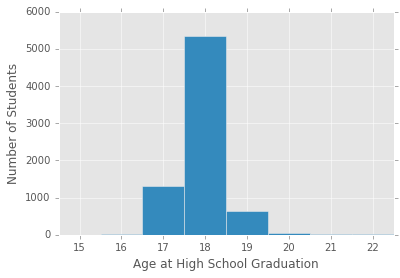

In [494]:
grads_age_at_graduation = get_student_age_from_graduation_dates(grads_dateofbirth, grads_dateofgraduation)

In [490]:
grads_age_at_graduation
labels, values = zip(*grads_age_at_graduation.items())
values = [x for y, x in sorted(zip(labels, values))]
labels = sorted(labels)
labels
values

Counter({15: 1, 16: 10, 17: 1324, 18: 5342, 19: 645, 20: 43, 21: 16, 22: 9})

[15, 16, 17, 18, 19, 20, 21, 22]

[1, 10, 1324, 5342, 645, 43, 16, 9]

In [486]:
zipped = zip([1, 2, 3], [4, 5, 6, 7]) # no error thrown when zipped objects are of different lengths
print([a+b for a,b in zipped])

[5, 7, 9]


In [453]:
student_num = 36427
grad_date = grads_dateofgraduation[3][student_num]
grad_date
dob = grads_dateofbirth[3][student_num]
dob
difference_in_years = relativedelta(grad_date, dob).years # how many years old is student at graduation
difference_in_years # this student is apparently 15 when graduated? 
# but this student had conflicting values in the data for their date of birth
get_student_field_from_districts(student_num, field_name)
# so from these conflicting values, 1996 seems a lot more likely than 1999, given that they graduated in 2014

Timestamp('2014-05-18 00:00:00')

Timestamp('1999-05-02 00:00:00')

15

Conflicting values for student 36427 in DATE_OF_BIRTH


{Timestamp('1996-05-02 00:00:00'), Timestamp('1999-05-02 00:00:00')}

<Container object of 14 artists>

<Container object of 14 artists>

(80, 100)

([<matplotlib.axis.XTick at 0x7ff2c828bf28>,
 <a list of 14 Text xticklabel objects>)

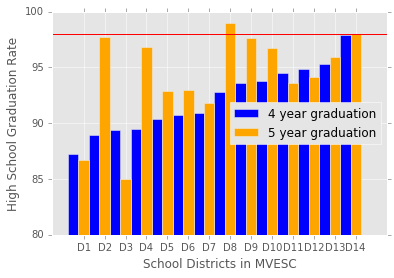

In [429]:
grad_4_year_rates = [94.9, 88.9, 89.5, 97.9, 95.3, 92.8, 87.2, 89.4, 90.9, 93.8, 94.5, 90.7, 93.6, 90.4]
grad_5_year_rates = [94.1, 97.7, 96.8, 98.0, 95.9, 99.0, 86.7, 85.0, 91.8, 96.7, 93.6, 93.0, 97.6, 92.9]
grad_5_year_rates = [x for y, x in sorted(zip(grad_4_year_rates, grad_5_year_rates))]
grad_4_year_rates.sort()

# arbitrary district codes, these don't match the ones in the data!
# fix district codes if reusing plot after deep dive presentation

ind = list(range(1,15))
shifted_ind = [i + width/2. for i in ind]
width = 1.0
district_codes = ["D" + str(i) for i in ind] 
plt.bar(ind, grad_4_year_rates, label = "4 year graduation", color = "blue", align = "center", width = width/2.)
plt.bar(shifted_ind, grad_5_year_rates, label = "5 year graduation", color = "orange", align = "center", width = width/2.)
plt.ylim(80, 100)
plt.xticks(shifted_ind, district_codes)
plt.xlabel("School Districts in MVESC")
plt.ylabel("High School Graduation Rate")
plt.legend(loc=5)
plt.axhline(y=98, hold=None, color="red")
plt.show()

In [420]:
[x for y, x in sorted(zip(grad_4_year_rates, grad_5_year_rates))]

[86.7,
 97.7,
 85.0,
 96.8,
 92.9,
 93.0,
 91.8,
 99.0,
 97.6,
 96.7,
 93.6,
 94.1,
 95.9,
 98.0]